In [4]:
!pip install functorch
from functorch import jacrev
from functorch import vmap

import os
import re
import torch
import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import os
import torch
import shutil
import argparse
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt


In [3]:
# science plots requirements
!apt-get update
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install SciencePlots
import matplotlib.pyplot as plt
plt.style.reload_library()
import scienceplots
plt.style.use('science')

# Helper functions


In [5]:
def attr_loss(forward_func, data_input, device='cpu', subsample=-1):

    ########## UPDATE functools ############
    batch_size = data_input.shape[0]
    def to_latent(input_):
        _, h_out = forward_func(input_)
        return h_out
    data_input = data_input.clone().requires_grad_(True)
    jacobian = vmap(jacrev(to_latent))(data_input)
    neuron_attr = jacobian.swapaxes(0,1)
    h_dim = neuron_attr.shape[0]
    
    if len(neuron_attr.shape) > 3:
        # h_dim x batch_size x features
        neuron_attr = neuron_attr.flatten(start_dim=2)

    sparsity_loss = torch.norm(neuron_attr, p=1)/(batch_size*h_dim*neuron_attr.shape[2])

    cos = nn.CosineSimilarity(dim=1, eps=1e-6)    
    correlation_loss = torch.tensor(0., requires_grad=True).to(device)
    
    if subsample > 0 and subsample < h_dim*(h_dim-1)/2:
        tensor_pairs = [list(np.random.choice(h_dim, size=(2), replace=False)) for i in range(subsample)]
        for tensor_pair in tensor_pairs:
            pairwise_corr = cos(neuron_attr[tensor_pair[0], :, :], neuron_attr[tensor_pair[1], :, :]).norm(p=1)
            correlation_loss = correlation_loss + pairwise_corr

        correlation_loss = correlation_loss/(batch_size*subsample)

    else:
        for neuron_i in range(1, h_dim):
            for neuron_j in range(0, neuron_i):
                pairwise_corr = cos(neuron_attr[neuron_i, :, :], neuron_attr[neuron_j, :, :]).norm(p=1)
                correlation_loss = correlation_loss + pairwise_corr
        num_pairs = h_dim*(h_dim-1)/2
        correlation_loss = correlation_loss/(batch_size*num_pairs)

    return sparsity_loss, correlation_loss



In [6]:
class parameter_schedule:
    def __init__(self, lambda_1, lambda_2, epoch):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.switch_epoch = epoch
        
    def get_reg(self, epoch):
        if epoch < self.switch_epoch:
            return 0, 0
        else:
            return self.lambda_1, self.lambda_2

def cosine_similarity(w1, w2):
    return torch.dot(w1, w2).abs()/(torch.norm(w1, 2)*torch.norm(w2, 2))

def weight_correlation(weights, device='cpu'):
    h_dim = weights.shape[0]

    weight_corr = torch.tensor(0., requires_grad=True).to(device)
    weights = weights.clone().requires_grad_(True)
    
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)   

    for neuron_i in range(1, h_dim):
        for neuron_j in range(0, neuron_i):
            pairwise_corr = cosine_similarity(weights[neuron_i, :], weights[neuron_j, :])
            weight_corr = weight_corr + pairwise_corr.norm(p=1)
    
    return weight_corr/(h_dim*(h_dim-1)/2)

In [7]:
class MNIST_CNN(nn.Module):
    def __init__(self, latent_dims=20):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 16, 5, 2, 0),                             
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 2, 0),     
            nn.ReLU()  
        )
        self.fc1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(256, latent_dims)
        self.relu2 = nn.ReLU(inplace=False)
        self.fc3 = nn.Linear(latent_dims, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if x.dim() == 4:
          x = x.view(x.size(0), -1)
        else:
          x = x.view(-1)
        x = self.relu1(self.fc1(x))
        h_output = self.fc2(x)
        out = self.fc3(h_output)
        return out, h_output

In [9]:
def load_mnist(BATCH_SIZE=128):

    train_data = datasets.MNIST(root='/content/',
                            train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]),
                            download=True)
    test_data = datasets.MNIST(root='/content/',
                            train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]),
                            download=True)

    loaders = {
            'train': DataLoader(train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=1),

            'test': DataLoader(test_data,
                            batch_size=int(BATCH_SIZE),
                            shuffle=True,
                            num_workers=1)
        }
    
    return loaders

In [ ]:
def train(model, loaders, loss_func, optimiser, log_writer, epoch,
          lambda_1=0, lambda_2=0, device='cpu', subsample=-1):
  
    sparsity_loss = torch.tensor([0])
    correlation_loss = torch.tensor([0])
        
    for i, (images, labels) in enumerate(loaders['train']):
        model.train()
        images, labels = images.to(device), labels.to(device)

        optimiser.zero_grad()   
        output, _ = model(images)
        pred_loss = loss_func(output, labels)
        if lambda_1 >0 or lambda_2 > 0:
            sparsity_loss, correlation_loss = attr_loss(model, images, device=device, subsample=subsample)

            loss = pred_loss + lambda_1*sparsity_loss + lambda_2*correlation_loss
        else:
            loss = pred_loss
    
        loss.backward()    
        optimiser.step()

        log_counter = epoch*len(loaders['train'])+i
        
        log_writer.add_scalar('TotalLoss/train', loss.item(), log_counter)
        log_writer.add_scalar('PredLoss/train', pred_loss.item(), log_counter)
        log_writer.add_scalar('SparsityLoss/train', sparsity_loss.item(), log_counter)
        log_writer.add_scalar('CorrelationLoss/train', correlation_loss.item(), log_counter)
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, i+1, len(loaders['train']), loss.item()))
            print(f"Lambda1: {lambda_1}, Lambda2: {lambda_2}")

    return model


def validate(model, loaders, loss_func, log_writer, epoch,
            lambda_1=0, lambda_2=0, device='cpu', subsample=-1):

    correct, total = 0, 0
    running_pred_loss, running_sparsity_loss, running_correlation_loss, running_total_loss = 0., 0., 0., 0.
    for i, (images, labels) in enumerate(loaders['test']):
        model.eval()

        images, labels = images.to(device), labels.to(device)

        output, _ = model(images)

        pred_loss = loss_func(output, labels)
        sparsity_loss, correlation_loss = attr_loss(model, images, device=device, subsample=subsample) 
        loss = pred_loss + lambda_1*sparsity_loss + lambda_2*correlation_loss

        pred_y = torch.max(output, 1)[1].data

        correct += (pred_y==labels).sum().item()
        total += float(labels.size()[0])

        running_pred_loss += pred_loss.item()
        running_sparsity_loss += sparsity_loss.item()
        running_correlation_loss += correlation_loss.item()
        running_total_loss += loss.item()

        del pred_loss
        del correlation_loss
        del sparsity_loss
        del loss

    accuracy = correct/total
    weight_corr = weight_correlation(model.fc1.weight.data)

    counter = len(loaders['test'])

    loss, pred_loss, sparsity_loss, correlation_loss = running_total_loss/counter, running_pred_loss/counter, \
                                                        running_sparsity_loss/counter, running_correlation_loss/counter

    log_writer.add_scalar('TotalLoss/test', loss, epoch)
    log_writer.add_scalar('PredLoss/test', pred_loss, epoch)
    log_writer.add_scalar('SparsityLoss/test', sparsity_loss, epoch)
    log_writer.add_scalar('CorrelationLoss/test', correlation_loss, epoch)
    log_writer.add_scalar('Accuracy/test', accuracy, epoch)
    log_writer.add_scalar('WeightCorrelation/test', weight_corr, epoch)

    print(f'[Test] accuracy: {accuracy:.4f}, pred loss: {pred_loss:.4f}, ' \
                f'sparsity loss: {sparsity_loss:.4f}, correlation loss: {correlation_loss:.4f}, ' \
                f'weight correlation: {weight_corr:.4f}')
    
    return pred_loss 

def main(runs=1, lambda_1=0, lambda_2=0):

    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-3
    EPOCHS = 10
    DEVICE = 'cuda'
    DATASET_NAME = 'mnist_cnn'
    TASK = 'class'

    param_schedule = -1
    subsample = 25
    latent_size = 10

    curr_dir = '/content'

    for seed in range(runs):

        torch.random.manual_seed(seed)
        exp_name = f'{DATASET_NAME}:{TASK}_latent:{latent_size}_'
        exp_setting = f'lambda1:{lambda_1}_lambda2:{lambda_2}_weightreg:{WEIGHT_DECAY}'
        exp_dir = exp_name + exp_setting
        run_name = f'run:{seed}'
        log_name = f'{curr_dir}/runs/{exp_dir}/{run_name}'
        model_save_dir =f'{curr_dir}/saved_models/{exp_dir}/'
        
        if os.path.exists(log_name):
            shutil.rmtree(log_name)
            print('old logs deleted...')

        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir)
            print('created path to save models...')

        loaders = load_mnist(BATCH_SIZE)
        model = MNIST_CNN(latent_size).to(DEVICE)
        print(f'Training on {DEVICE}...')
        loss_func = nn.CrossEntropyLoss()   
        optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)   
        writer = SummaryWriter(log_dir=log_name)
        parameter_scheduler = parameter_schedule(lambda_1, lambda_2, param_schedule)

        model_save_path = f'{model_save_dir}/{run_name}.pt'
        best_loss = np.inf

        for epoch in range(EPOCHS):
            lambda_1, lambda_2 = parameter_scheduler.get_reg(epoch)

            model = train(model, loaders, loss_func, optimiser, log_writer=writer,
                        epoch=epoch, lambda_1=lambda_1, lambda_2=lambda_2,
                        device=DEVICE, subsample=subsample)

            val_loss = validate(model, loaders, loss_func, log_writer=writer, epoch=epoch,
                                    lambda_1=lambda_1, lambda_2=lambda_2, device=DEVICE, subsample=subsample)

            if val_loss < best_loss and epoch >= param_schedule:
                print(f'Epoch {epoch} - Validation performance improved, saving model...')
                best_loss = val_loss
                torch.save(model.state_dict(), model_save_path)
                    

# Train and save a model with or without TANGOS regularization. Later we will analyze the attributions of this model.

In [ ]:
runs = 1
main(runs=runs, lambda_1=0, lambda_2=0)

# Analysis of gradient attributions

In [28]:
# logic for plotting saliency maps
def plot_saliency_mnist(forward_func, data_input, h_layer, label=None, device='cpu', 
                            plot_dir='results/', plot_prefix='', plot_abs_val=True):

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    subtitsize = 15
    cbar_font = 15

    fig = plt.figure(figsize=(10, 3.2))
    gs = GridSpec(2,7)
    axes = []
    for i in range(2):
      for j in range(5):
        ax=fig.add_subplot(gs[i,j+2])
        axes.append(ax)
    num_ax=fig.add_subplot(gs[0:2,0:2])
    num_ax.imshow(data_input.squeeze(), cmap='gray', interpolation=None)
    num_ax.axis('off')

    data_input = data_input.float().requires_grad_(True).to(device)
    data_input = data_input.unsqueeze(0).unsqueeze(0)
    
    pred, h_output = forward_func(data_input)
    weight = forward_func.fc3.weight.data
    bias = forward_func.fc3.bias.data.unsqueeze(-1)
    if label is not None:
        label_weights = weight[label,:]
        contributions = label_weights * h_output
        # pred = contributions.sum() + bias[label,0]

    batch_size = data_input.shape[0]
    def to_latent(input_):
        _, h_out = forward_func(input_)
        return h_out
    data_input = data_input.clone().requires_grad_(True)
    jacobian = vmap(jacrev(to_latent))(data_input)
    neuron_attr = jacobian.swapaxes(0,1)
    h_dim = neuron_attr.shape[0]

    if plot_abs_val:
        neuron_attr = neuron_attr.abs().squeeze()
    else:
        neuron_attr = neuron_attr.squeeze()
    
    v_min, v_max = neuron_attr.min(), neuron_attr.max()
    abs_max = max(v_min.abs().item(), v_max.abs().item())
    
    if h_layer:
        importance_weights = getattr(forward_func, h_layer).weight.data

    for count in range(h_dim):
        # ax = axes.flat[count]
        saliency = neuron_attr[count, :, :]
        if plot_abs_val:
            im = axes[count].imshow(saliency.cpu().detach().numpy(), interpolation='none',\
                       cmap='Blues', vmin=0, vmax=abs_max)
        else:
            im = axes[count].imshow(saliency.cpu().detach().numpy(), interpolation='none',\
                           cmap='coolwarm', vmin=-abs_max, vmax=abs_max)

        if h_layer:
            activation = h_output[0,count]
            weights_norm = importance_weights[count, :].norm(p=1)
            axes[count].set_title(f'H{count+1} = {activation:.2f}', fontsize=subtitsize,
                                  pad=0)
        else:
            axes[count].set_title(f'Neuron {count+1}')
        axes[count].axis('off')
            
        #cmap coolwarm for pos and neg
    plt.tight_layout()
    # add colorbar
    fig.subplots_adjust(right=0.83)
    cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.8])  #[0.85, 0.15, 0.05, 0.7]
    cbar = fig.colorbar(im, cax=cbar_ax)
    max_range_cb = max([v_max.item(), -1*v_min.item()])
    eps = max_range_cb/7
    cbar.set_ticks([-1*max_range_cb+eps,0,max_range_cb-eps])
    cbar.set_ticklabels(['Strong\nNegative', '     0', 'Strong\nPositive'])
    cbar.ax.tick_params(labelsize=cbar_font)
    cbar.ax.yaxis.set_tick_params(pad=8)

    # plt.savefig(plot_dir+plot_prefix+"_saliency_maps.pdf")
    plt.show()



0


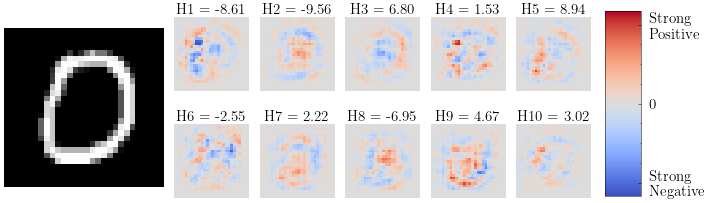

1


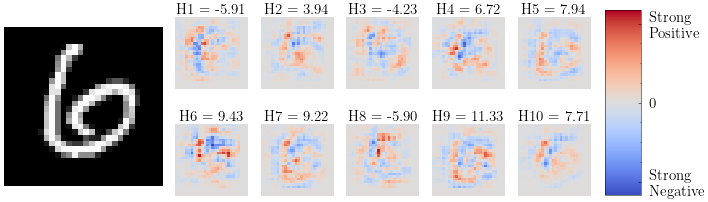

2


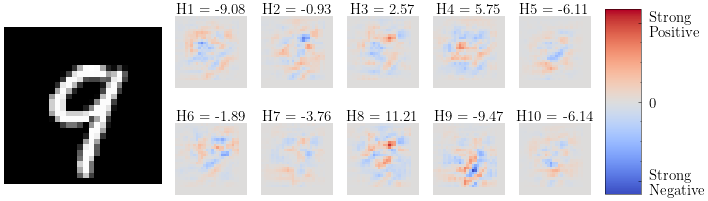

In [19]:
# lets plot the gradient attributions of the 10 latent units for a selction of samples
DEVICE='cuda'
curr_dir = os.getcwd()
exp_dir ='mnist_cnn:class_latent:10_lambda1:0_lambda2:0_weightreg:0.001'  # make sure this matches the trained model
load_model_path =f'{curr_dir}/saved_models/{exp_dir}/run:0.pt'
num_samples=3
latent_size = 10

test_data = datasets.MNIST(root='/content/',
                        train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]),
                        download=True)
data = DataLoader(test_data,
                  batch_size=num_samples+10,
                  shuffle=False,
                  num_workers=1)

cnn = MNIST_CNN(latent_size).to(DEVICE)
cnn.load_state_dict(torch.load(load_model_path))

for img, label in data:
  break

for sample in range(num_samples):
    print(sample)
    plot_saliency_mnist(cnn, img[sample+10,0], label=label[sample+10] ,h_layer='fc2', device=DEVICE, \
                        plot_dir=f'results/{exp_dir}/', plot_prefix=f'mnist_sample_{sample+1}', plot_abs_val=False)


In [26]:
# finally we will plot a selection of samples for a given latent unit
DEVICE='cuda'
curr_dir = os.getcwd()
exp_dir ='mnist_cnn:class_latent:10_lambda1:0_lambda2:0_weightreg:0.001'
load_model_path =f'{curr_dir}/saved_models/{exp_dir}/run:0.pt'
num_samples=10
latent_size = 10

test_data = datasets.MNIST(root='/content/',
                        train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]),
                        download=True)
data = DataLoader(test_data,
                  batch_size=num_samples+10,
                  shuffle=False,
                  num_workers=1)

cnn = MNIST_CNN(latent_size).to(DEVICE)
cnn.load_state_dict(torch.load(load_model_path))

for img, label in data:
  break


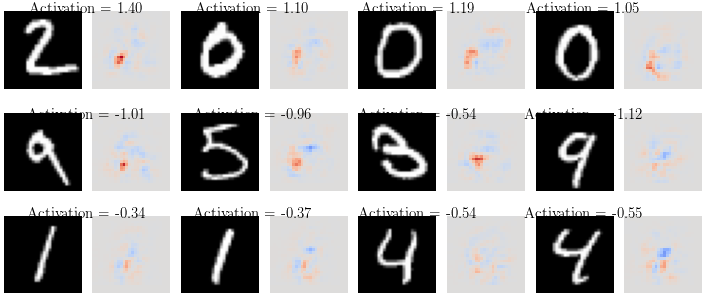

In [ ]:
data_input = img
forward_func = cnn
device = 'cuda'

data_input = data_input.float().requires_grad_(True).to(device)

pred, h_output = forward_func(data_input)

batch_size = data_input.shape[0]
def to_latent(input_):
    _, h_out = forward_func(input_)
    return h_out
data_input = data_input.clone().requires_grad_(True)
jacobian = vmap(jacrev(to_latent))(data_input)
neuron_attr = jacobian.swapaxes(0,1)
h_dim = neuron_attr.shape[0]
selected_idx = [1,3,10,13,7,15,18,12,2,5,4,6]
selected_neuron = 4
saliency = neuron_attr.cpu().detach()#.numpy()
saliency = saliency.index_select(1, torch.tensor(selected_idx)).squeeze(2)
saliency = saliency[selected_neuron]
v_min, v_max = saliency.min(), saliency.max()
abs_max = max(v_min.abs(), v_max.abs())

activations = h_output.cpu().detach()
activations = activations.index_select(0, torch.tensor(selected_idx)).numpy()
activations = activations[:,selected_neuron]

subtitsize = 15
cbar_font = 15

fig = plt.figure(figsize=(10, 4.6))
gs = GridSpec(3,8)
axes = []
for i in range(3):
  for j in range(4):
    ax1=fig.add_subplot(gs[i,j*2:j*2+1])
    ax2=fig.add_subplot(gs[i,j*2+1:j*2+2])
    axes.append(ax1)
    axes.append(ax2)

input_imgs = data_input.cpu().detach().numpy().squeeze(1)
for cnt, idx in enumerate(selected_idx):
    im = axes[cnt*2].imshow(input_imgs[idx], cmap='gray', interpolation=None)
    axes[cnt*2].axis('off')
    im = axes[cnt*2+1].imshow(saliency[cnt], interpolation='none',\
                           cmap='coolwarm', vmin=-abs_max, vmax=abs_max)
    axes[cnt*2+1].axis('off')
    width_buffer = 0.13
    shared_width = 0.23
    tot = width_buffer+(cnt%4)*shared_width
    # tot = tot % 1
    if cnt < 4:
      h = 0.92
    elif cnt < 8:
      h = 0.6
    else:
      h = 0.3
    # h = 0.88 if cnt < 4 else 0.45
    plt.gcf().text(tot, h, f'Activation = {activations[cnt]:.2f}', 
                   fontsize=subtitsize, ha="center")

plt.tight_layout()
plt.show()